## MOSAIKS feature extraction

This tutorial demonstrates the **MOSAIKS** method for extracting _feature vectors_ from satellite imagery patches for use in downstream modeling tasks. It will show:
- How to extract 1km$^2$ patches of Sentinel 2 multispectral imagery for a list of latitude, longitude points
- How to extract summary features from each of these imagery patches
- How to use the summary features in a linear model of the population density at each point

### Background

Consider the case where you have a dataset of latitude and longitude points assosciated with some dependent variable (for example: population density, weather, housing prices, biodiversity) and, potentially, other independent variables. You would like to model the dependent variable as a function of the independent variables, but instead of including latitude and longitude directly in this model, you would like to include some high dimensional representation of what the Earth looks like at that point (that hopefully explains some of the variance in the dependent variable!). From the computer vision literature, there are various [representation learning techniques](https://en.wikipedia.org/wiki/Feature_learning) that can be used to do this, i.e. extract _features vectors_ from imagery. This notebook gives an implementation of the technique described in [Rolf et al. 2021](https://www.nature.com/articles/s41467-021-24638-z), "A generalizable and accessible approach to machine learning with global satellite imagery" called Multi-task Observation using Satellite Imagery & Kitchen Sinks (**MOSAIKS**). 


**Notes**:
- This example uses [Sentinel-2 Level-2A data](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a). The techniques used here apply equally well to other remote-sensing datasets.
- If you're running this on the [Planetary Computer Hub](http://planetarycomputer.microsoft.com/compute), make sure to choose the **GPU - PyTorch** profile when presented with the form to choose your environment.

In [63]:
import warnings
import time
import os

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning

warnings.filterwarnings(action="ignore", category=LinAlgWarning, module="sklearn")

from pystac_client import Client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

First we define the pytorch model that we will use to extract the features and a helper method. The **MOSAIKS** methodology describes several ways to do this and we use the simplest.

In [2]:
def featurize(input_img, model, device):
    """Helper method for running an image patch through the model.

    Args:
        input_img (np.ndarray): Image in (C x H x W) format with a dtype of uint8.
        model (torch.nn.Module): Feature extractor network
    """
    assert len(input_img.shape) == 3
    input_img = torch.from_numpy(input_img / 255.0).float()
    input_img = input_img.to(device)
    with torch.no_grad():
        feats = model(input_img.unsqueeze(0)).cpu().numpy()
    return feats


class RCF(nn.Module):
    """A model for extracting Random Convolution Features (RCF) from input imagery."""

    def __init__(self, num_features=16, kernel_size=3, num_input_channels=3):
        super(RCF, self).__init__()

        # We create `num_features / 2` filters so require `num_features` to be divisible by 2
        assert num_features % 2 == 0

        self.conv1 = nn.Conv2d(
            num_input_channels,
            num_features // 2,
            kernel_size=kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            bias=True,
        )

        nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
        nn.init.constant_(self.conv1.bias, -1.0)

    def forward(self, x):
        x1a = F.relu(self.conv1(x), inplace=True)
        x1b = F.relu(-self.conv1(x), inplace=True)

        x1a = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()
        x1b = F.adaptive_avg_pool2d(x1b, (1, 1)).squeeze()

        if len(x1a.shape) == 1:  # case where we passed a single input
            return torch.cat((x1a, x1b), dim=0)
        elif len(x1a.shape) == 2:  # case where we passed a batch of > 1 inputs
            return torch.cat((x1a, x1b), dim=1)

Next, we initialize the model and pytorch components

In [3]:
num_features = 1024

device = torch.device("cuda")
model = RCF(num_features).eval().to(device)

### Read dataset of (lat, lon) points and corresponding labels

We read a CSV of 100,000 randomly sampled (lat, lon) points over the US and the corresponding population living roughly within 1km$^2$ of the points from the [Gridded Population of the World](https://sedac.ciesin.columbia.edu/downloads/data/gpw-v4/gpw-v4-population-density-rev10/gpw-v4-population-density-rev10_2015_30_sec_tif.zip) dataset. This data comes from the [Code Ocean capsule](https://codeocean.com/capsule/6456296/tree/v2) that accompanies the Rolf et al. 2021 paper.

In [4]:
df = pd.read_csv(
    "https://files.codeocean.com/files/verified/fa908bbc-11f9-4421-8bd3-72a4bf00427f_v2.0/data/int/applications/population/outcomes_sampled_population_CONTUS_16_640_UAR_100000_0.csv?download",  # noqa: E501
    index_col=0,
)
points = df[["lon", "lat"]].values
population = df["population"].values

Always look at your data!

In [5]:
print("Population:", population.min(), population.max())
print("Longitude:", points[:, 0].min(), points[:, 0].max())
print("Latitude:", points[:, 1].min(), points[:, 1].max())
print("")
print(points.shape, population.shape)

Population: -999.0 27620.9173126221
Longitude: -124.655689061796 -67.0731277565878
Latitude: 25.1505787230138 49.286621904709

(100000, 2) (100000,)


Get rid of points with nodata population values

In [6]:
nodata_mask = population >= 0
population = population[nodata_mask]
points = points[nodata_mask]

In [7]:
print(points.shape, population.shape)

(67968, 2) (67968,)


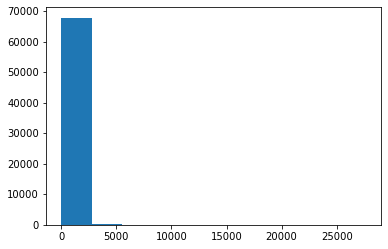

In [8]:
plt.figure()
plt.hist(population)
plt.show()
plt.close()

Population is lognormal distributed, so transforming it to log-space makes sense for modeling purposes

In [9]:
population_log = np.log10(population + 1)

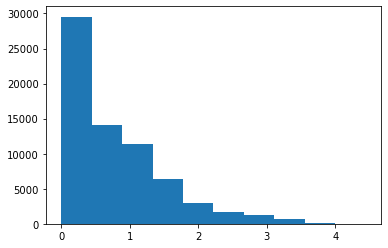

In [10]:
plt.figure()
plt.hist(population_log)
plt.show()
plt.close()

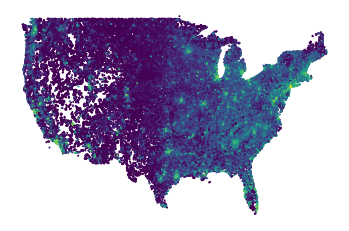

In [11]:
plt.figure()
plt.scatter(points[:, 0], points[:, 1], c=population_log, s=1)
plt.axis("off")
plt.show()
plt.close()

### Extract features from the imagery around each point

We perform the feature extraction step in three parts:
- For each of the 67,968 remaining points we want to find the corresponding S2 scene that we'll use to extract features from. We don't want to simply make 67,968 STAC API calls, so instead we will find the appropriate scene for a point with the STAC API, then find all other points that the scene covers until we have a matching scene for each point.
- We'll create a custom PyTorch Dataset that can read imagery given a point and the URL of a overlapping S2 scene
- We'll create Dataloader using the Dataset, then use it to feed our model imagery and save the corresponding features

In [12]:
def update_matching_urls_by_item(item):
    """Determine which of the unmatched points a given STAC item covers and record the signed
    URL for those points.
    """
    href = item.assets["visual"].href
    signed_href = pc.sign(href)
    bbox = shapely.geometry.box(*least_cloudy_item.bbox)

    num_updated = 0
    for i, (lon, lat) in enumerate(points):
        if matching_urls[i] is None:
            point_shape = shapely.geometry.Point(lon, lat)
            if bbox.contains(point_shape):
                matching_urls[i] = signed_href
                num_updated += 1
    return num_updated

In [13]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# The time frame in which we search for non-cloudy imagery
search_start = "2018-01-01"
search_end = "2019-12-31"

# `matching_urls[i]` will contain the Planetary Computer signed URL
# to the GeoTIFF that contains `points[i]`
matching_urls = [None for i in range(points.shape[0])]

tic = time.time()
iterations = 0
num_found = 0
for i, (lon, lat) in enumerate(points):
    if matching_urls[i] is None:

        point_shape = shapely.geometry.Point(lon, lat)
        point_geom = shapely.geometry.mapping(point_shape)

        search = catalog.search(
            collections=["sentinel-2-l2a"],
            intersects=point_geom,
            datetime=f"{search_start}/{search_end}",
            query={"eo:cloud_cover": {"lt": 10}},
        )
        items = list(search.get_items())
        if len(items) > 0:
            least_cloudy_item = sorted(
                items, key=lambda item: eo.ext(item).cloud_cover
            )[0]
            num_updated = update_matching_urls_by_item(least_cloudy_item)
            num_found += num_updated
            print(
                f"Found imagery for {num_updated} points, {points.shape[0] - num_found}"
                + f" remaining -- {time.time()-tic:0.2f} seconds elapsed"
            )
            iterations += 1
        else:
            print(f"Didn't find a matching scene for ({lon}, {lat})")
    else:
        pass  # We have already found a S2 scene that covers this point!

Found imagery for 106 points, 67862 remaining -- 1.64 seconds elapsed
Found imagery for 115 points, 67747 remaining -- 2.80 seconds elapsed
Found imagery for 149 points, 67598 remaining -- 3.84 seconds elapsed
Found imagery for 98 points, 67500 remaining -- 5.01 seconds elapsed
Found imagery for 132 points, 67368 remaining -- 6.09 seconds elapsed
Found imagery for 191 points, 67177 remaining -- 7.11 seconds elapsed
Found imagery for 66 points, 67111 remaining -- 8.17 seconds elapsed
Found imagery for 130 points, 66981 remaining -- 9.22 seconds elapsed
Found imagery for 109 points, 66872 remaining -- 10.37 seconds elapsed
Found imagery for 63 points, 66809 remaining -- 11.36 seconds elapsed
Found imagery for 85 points, 66724 remaining -- 12.39 seconds elapsed
Found imagery for 57 points, 66667 remaining -- 13.49 seconds elapsed
Found imagery for 12 points, 66655 remaining -- 14.92 seconds elapsed
Found imagery for 153 points, 66502 remaining -- 16.00 seconds elapsed
Found imagery for 19

In [14]:
print(f"We called the STAC API {iterations} times")

We called the STAC API 1068 times


In [15]:
class CustomDataset(Dataset):
    def __init__(self, points, fns, buffer=500):
        self.points = points
        self.fns = fns
        self.buffer = buffer

    def __len__(self):
        return self.points.shape[0]

    def __getitem__(self, idx):

        lon, lat = self.points[idx]
        fn = self.fns[idx]

        if fn is None:
            return None
        else:
            point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))

            with rasterio.Env():
                with rasterio.open(fn, "r") as f:
                    point_geom = rasterio.warp.transform_geom(
                        "epsg:4326", f.crs.to_string(), point_geom
                    )
                    point_shape = shapely.geometry.shape(point_geom)
                    mask_shape = point_shape.buffer(self.buffer).envelope
                    mask_geom = shapely.geometry.mapping(mask_shape)
                    try:
                        out_image, out_transform = rasterio.mask.mask(
                            f, [mask_geom], crop=True
                        )
                    except ValueError as e:
                        if "Input shapes do not overlap raster." in str(e):
                            return None

            out_image = out_image / 255.0
            out_image = torch.from_numpy(out_image).float()
            return out_image

In [16]:
dataset = CustomDataset(points, matching_urls)

dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    num_workers=os.cpu_count() * 2,
    collate_fn=lambda x: x,
    pin_memory=False,
)

In [17]:
x_all = np.zeros((points.shape[0], num_features), dtype=float)

tic = time.time()
i = 0
for images in dataloader:
    for image in images:

        if image is not None:
            # A full image should be ~101x101 pixels (i.e. ~1km^2 at a 10m/px spatial
            # resolution), however we can receive smaller images if an input point
            # happens to be at the edge of a S2 scene (a literal edge case). To deal
            # with these (edge) cases we crudely drop all images where the spatial
            # dimensions aren't both greater than 20 pixels.
            if image.shape[1] >= 20 and image.shape[2] >= 20:
                image = image.to(device)
                with torch.no_grad():
                    feats = model(image.unsqueeze(0)).cpu().numpy()

                x_all[i] = feats
            else:
                # this happens if the point is close to the edge of a scene
                # (one or both of the spatial dimensions of the image are very small)
                pass
        else:
            pass  # this happens if we do not find a S2 scene for some point

        if i % 1000 == 0:
            print(
                f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f}%"
                + f" -- {time.time()-tic:0.2f} seconds"
            )
            tic = time.time()
        i += 1

0/67968 -- 0.00% -- 2.51 seconds
1000/67968 -- 1.47% -- 19.50 seconds
2000/67968 -- 2.94% -- 16.81 seconds
3000/67968 -- 4.41% -- 16.17 seconds
4000/67968 -- 5.89% -- 16.56 seconds
5000/67968 -- 7.36% -- 18.00 seconds
6000/67968 -- 8.83% -- 15.62 seconds
7000/67968 -- 10.30% -- 16.92 seconds
8000/67968 -- 11.77% -- 15.36 seconds
9000/67968 -- 13.24% -- 16.01 seconds
10000/67968 -- 14.71% -- 16.29 seconds
11000/67968 -- 16.18% -- 17.38 seconds
12000/67968 -- 17.66% -- 16.42 seconds
13000/67968 -- 19.13% -- 17.08 seconds
14000/67968 -- 20.60% -- 16.30 seconds
15000/67968 -- 22.07% -- 16.51 seconds
16000/67968 -- 23.54% -- 15.98 seconds
17000/67968 -- 25.01% -- 16.44 seconds
18000/67968 -- 26.48% -- 15.76 seconds
19000/67968 -- 27.95% -- 15.69 seconds
20000/67968 -- 29.43% -- 16.88 seconds
21000/67968 -- 30.90% -- 16.27 seconds
22000/67968 -- 32.37% -- 16.23 seconds
23000/67968 -- 33.84% -- 16.21 seconds
24000/67968 -- 35.31% -- 15.29 seconds
25000/67968 -- 36.78% -- 16.94 seconds
26000/6

### Use the extracted features and given labels to model population density as a function of imagery

We split the available data 80/20 into train/test. We use a cross-validation approach to tune the regularization parameter of a Ridge regression model, then apply the model to the test data and measure the R2.

In [18]:
y_all = population_log.copy()

In [19]:
x_all.shape, y_all.shape

((67968, 1024), (67968,))

And one final masking -- any sample that has all zeros for features means that we were unsuccessful at extracting features for that point.

In [20]:
nofeature_mask = ~(x_all.sum(axis=1) == 0)

In [21]:
x_all = x_all[nofeature_mask]
y_all = y_all[nofeature_mask]

In [22]:
x_all.shape, y_all.shape

((66920, 1024), (66920,))

In [61]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [62]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [64]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.54


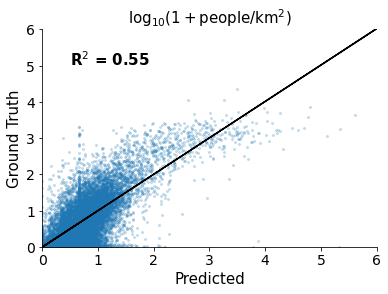

In [81]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=0.2, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.title(r"$\log_{10}(1 + $people$/$km$^2)$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([0, 6])
plt.ylim([0, 6])

plt.text(
    0.5,
    5,
    s="R$^2$ = %0.2f" % (r2_score(y_test, y_pred)),
    fontsize=15,
    fontweight="bold",
)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.show()
plt.close()

In addition to a R$^2$ value of ~0.55 on the test points, we can see that we have a rank-order correlation (spearman's r) of 0.66.

In [75]:
spearmanr(y_pred, y_test)

SpearmanrResult(correlation=0.6639474687140459, pvalue=0.0)

### Spatial extrapolation

In the previous section we split the points randomly and found that our model can _interpolate_ population density with an R2 of 0.55, however this result does not say anything about how well the model will extrapolate. Whenever you are modeling spatio-temporal data it is important to consider what the model is doing as well as the purpose of the model, then evaluate it appropriately. Here, we test how our modeling approach above is able to extrapolate to areas that it has not been trained on. Specifically we train the linear model with data from the _western_ portion of the US then test it on data from the _eastern_ US and interpret the results.

In [27]:
points = points[nofeature_mask]

First we calculate the 80th percentile longitude of the points in our dataset. Points that are to the west of this value will be in our training split and points to the east of this will be in our testing split.

In [84]:
split_lon = np.percentile(points[:, 0], 80)
train_idxs = np.where(points[:, 0] <= split_lon)[0]
test_idxs = np.where(points[:, 0] > split_lon)[0]

x_train = x_all[train_idxs]
x_test = x_all[test_idxs]
y_train = y_all[train_idxs]
y_test = y_all[test_idxs]

Visually, the split looks like this:

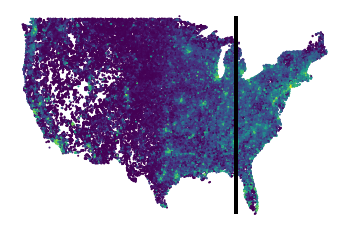

In [85]:
plt.figure()
plt.scatter(points[:, 0], points[:, 1], c=y_all, s=1)
plt.vlines(
    split_lon,
    ymin=points[:, 1].min(),
    ymax=points[:, 1].max(),
    color="black",
    linewidth=4,
)
plt.axis("off")
plt.show()
plt.close()

In [87]:
ridge_cv = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

We can see that our validation performance is similar to that of the random split:

In [88]:
print(f"Validation R2 performance {ridge_cv.best_score_:0.2f}")

Validation R2 performance 0.52


However, our _test_ R$^2$ is much lower, 0.13 compared to 0.55. This shows that the linear model trained on **MOSAIKS** features and population data sampled from the _western_ US is not able to predict the population density in the _eastern_ US as well. However, from the scatter plot we can see that the predictions aren't random which warrants further investigation...

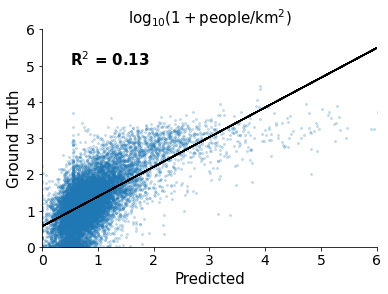

In [89]:
y_pred = np.maximum(ridge_cv.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=0.2, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.title(r"$\log_{10}(1 + $people$/$km$^2)$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([0, 6])
plt.ylim([0, 6])

plt.text(
    0.5,
    5,
    s="R$^2$ = %0.2f" % (r2_score(y_test, y_pred)),
    fontsize=15,
    fontweight="bold",
)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.show()
plt.close()

The rank-order correlation is still high, 0.61 compared to 0.66 from the random split. This shows that the model is still able to correctly _order_ the density of input points, however is wrong about the magnitude of the population densities.

In [90]:
spearmanr(y_test, y_pred)

SpearmanrResult(correlation=0.6057418069626541, pvalue=0.0)

This makes sense when we compare the distributions of population density of points from the western US to that of the eastern US -- the label distributions are completely different. The distribution of **MOSAIKS** features likely doesn't change, however the mapping between these features and population density definitely varies with space.

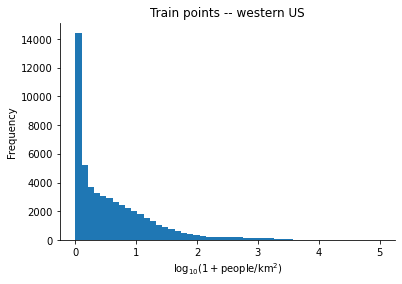

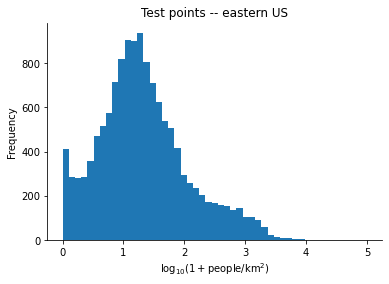

In [93]:
bins = np.linspace(0, 5, num=50)

plt.figure()
plt.hist(y_train, bins=bins)
plt.ylabel("Frequency")
plt.xlabel(r"$\log_{10}(1 + $people$/$km$^2)$")
plt.title("Train points -- western US")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.show()
plt.close()

plt.figure()
plt.hist(y_test, bins=bins)
plt.ylabel("Frequency")
plt.xlabel(r"$\log_{10}(1 + $people$/$km$^2)$")
plt.title("Test points -- eastern US")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.show()
plt.close()

Estimating the _relative_ population density of points from the corresponding imagery is still useful in a wide variety of applications, e.g. in disaster reponse settings it might make sense to allocate the most resources to the most densely populated locations, where the precise density isn't as important.